# Northwestern County 1st Time Home Buyer Analysis

Author: Armun Shakeri

# Overview

This project analyzes types of homes available in today's housing market and examines which of those homes would be appropriate for a first time home buyer. 

# Business Problem

Recently property values have been increasing throughout the United States. For those wanting to buy their first home,  there are many factors that might raise the price of that home. This project analyzes these factors and explores if they do have a positive or negative affect on the houses' value. 

# Data Understanding

The following data is imported from KC housing data and shows different information about homes such as the date a home was sold, price, bedrooms...etc. For this project we will only use some of the data available, others will be removed.

In [1]:
# Import standard packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Run code to explore the data
kc = pd.read_csv('data/kc_house_data.csv')

In [3]:
# this shows information regarding variables in kc dataframe 
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
# Below we drop values that are irrelevant towards first time hombe buyer analysis 
kc = kc.drop(['date', 'view', 'sqft_above', 'sqft_basement', 'zipcode', 'sqft_living15', 
        'sqft_lot15', 'waterfront', 'grade', 'lat', 'long'], axis=1)
kc.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,1955,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,1951,1991.0
2,5631500400,180000.0,2,1.00,770,10000,1.0,Average,1933,NaN
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,1965,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,1987,0.0


In [5]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            21597 non-null  int64  
 1   price         21597 non-null  float64
 2   bedrooms      21597 non-null  int64  
 3   bathrooms     21597 non-null  float64
 4   sqft_living   21597 non-null  int64  
 5   sqft_lot      21597 non-null  int64  
 6   floors        21597 non-null  float64
 7   condition     21597 non-null  object 
 8   yr_built      21597 non-null  int64  
 9   yr_renovated  17755 non-null  float64
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB


In [6]:
# Here we drop all Na values. 
kc=kc.dropna()

In [7]:
# First time home buyers will not be looking at homes over $1,000,000. Homes above that threshold will be removed. 
# Homes with bedrooms at or above 4, and greater than 2 floors will also be removed. 
kc = kc[kc.price<=1000000][kc.bedrooms<=10]
kc.head()

<ipython-input-7-4f7939aed66f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  kc = kc[kc.price<=1000000][kc.bedrooms<=10]


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated
0,7129300520,221900.0,3,1.00,1180,5650,1.0,Average,1955,0.0
1,6414100192,538000.0,3,2.25,2570,7242,2.0,Average,1951,1991.0
3,2487200875,604000.0,4,3.00,1960,5000,1.0,Very Good,1965,0.0
4,1954400510,510000.0,3,2.00,1680,8080,1.0,Average,1987,0.0
6,1321400060,257500.0,3,2.25,1715,6819,2.0,Average,1995,0.0


In [8]:
# changed year renovated from float64 to int
kc.yr_renovated=kc.yr_renovated.astype(int)

In [9]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16560 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            16560 non-null  int64  
 1   price         16560 non-null  float64
 2   bedrooms      16560 non-null  int64  
 3   bathrooms     16560 non-null  float64
 4   sqft_living   16560 non-null  int64  
 5   sqft_lot      16560 non-null  int64  
 6   floors        16560 non-null  float64
 7   condition     16560 non-null  object 
 8   yr_built      16560 non-null  int64  
 9   yr_renovated  16560 non-null  int64  
dtypes: float64(3), int64(6), object(1)
memory usage: 1.4+ MB


In [10]:
kc.sort_values('yr_renovated', ascending=False).head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,yr_built,yr_renovated
2293,8712100320,585000.0,5,2.75,2350,4178,1.5,Average,1922,2015
14845,3585900665,805000.0,5,2.50,4600,19831,1.0,Average,1956,2015
11621,461004730,717000.0,3,1.00,1150,5000,1.0,Average,1959,2015
11587,7284900030,850000.0,4,3.25,3090,6744,2.0,Average,1923,2015
4236,6071800100,815000.0,6,3.00,2860,17853,1.0,Average,1962,2015


In [11]:
# Build correlation matrix
corr = kc.corr()
corr

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
id,1.000000,0.016214,0.017894,0.024422,0.012727,-0.134737,0.032600,0.025843,-0.016092
price,0.016214,1.000000,0.296413,0.437202,0.604143,0.091391,0.268628,0.056264,0.082004
bedrooms,0.017894,0.296413,1.000000,0.503331,0.605216,0.024425,0.158935,0.166043,-0.003158
bathrooms,0.024422,0.437202,0.503331,1.000000,0.709130,0.060016,0.500801,0.550520,0.020570
sqft_living,0.012727,0.604143,0.605216,0.709130,1.000000,0.154373,0.335575,0.356581,0.015740
sqft_lot,-0.134737,0.091391,0.024425,0.060016,0.154373,1.000000,-0.020455,0.037375,0.008266
floors,0.032600,0.268628,0.158935,0.500801,0.335575,-0.020455,1.000000,0.511824,-0.006913
yr_built,0.025843,0.056264,0.166043,0.550520,0.356581,0.037375,0.511824,1.000000,-0.217050
yr_renovated,-0.016092,0.082004,-0.003158,0.020570,0.015740,0.008266,-0.006913,-0.217050,1.000000


# Data Modeling

In [12]:
# Here shows the different statistical values of the kc dataframe
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
count,1.656000e+04,16560.000000,16560.000000,16560.000000,16560.000000,1.656000e+04,16560.000000,16560.000000,16560.000000
mean,4.614280e+09,468446.169384,3.326087,2.043825,1959.337440,1.473482e+04,1.473339,1970.861292,72.169807
std,2.877294e+09,196567.305225,0.882051,0.700371,754.721495,4.108286e+04,0.534796,29.095255,372.563550
min,1.000102e+06,80000.000000,1.000000,0.500000,370.000000,5.200000e+02,1.000000,1900.000000,0.000000
25%,2.148550e+09,314150.000000,3.000000,1.500000,1400.000000,5.000000e+03,1.000000,1952.000000,0.000000
50%,3.918400e+09,435000.000000,3.000000,2.000000,1850.000000,7.500000e+03,1.000000,1974.000000,0.000000
75%,7.345000e+09,594122.750000,4.000000,2.500000,2420.000000,1.025425e+04,2.000000,1996.000000,0.000000
max,9.895000e+09,1000000.000000,10.000000,7.500000,7120.000000,1.651359e+06,3.500000,2015.000000,2015.000000


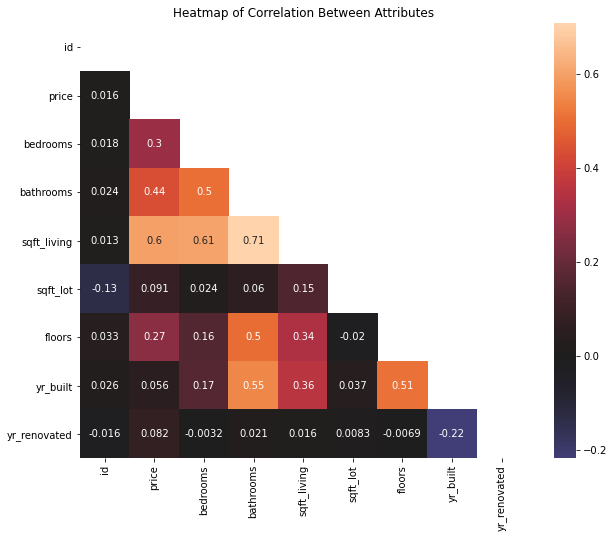

In [13]:
# Build heatmap


# Set up figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(kc.corr(), 
            # Mask to show only half the values instead of showing duplicates
            mask=np.triu(np.ones_like(corr, dtype=bool)),
            # Specifies that we want values not just colors
            annot = True,
            center=0);

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes");

# We see below that the highest to lowest correlated are as follows:
# 1) sqft_living vs. bathrooms 
# 2) sqft_living vs. price 
# 3) sqft_living vs. bedrooms

In [15]:
# Function to calculate slope
X = kc['bathrooms']
y = kc['sqft_living']

def calc_slope(xs, ys):
    
    m = (((np.mean(xs)*np.mean(ys)) - np.mean(xs*ys)) /
         ((np.mean(xs)**2) - np.mean(xs*xs)))
    
    return m

calc_slope(X,y)


764.1608986514516

In [16]:
# Function for line of best fit

def best_fit(xs,ys):
    
    m = calc_slope(xs,ys)
    c = np.mean(ys) - m*np.mean(xs)
    
    return m, c

m, c = best_fit(X,y)
m, c

(764.1608986514516, 397.525921767369)

In [17]:
# Create reg_line function

def reg_line (m, c, xs):
    
    return [(m*x)+c for x in xs]

regression_line = reg_line(m,c,X)

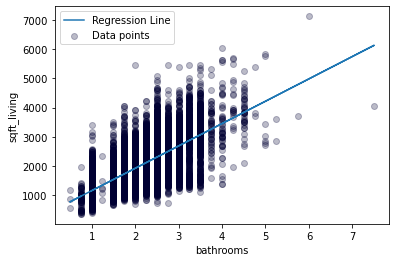

In [18]:
# Plot points with regression line

plt.scatter(X,y,color='#0034',label="Data points")
plt.plot(X, regression_line, label= "Regression Line")

plt.xlabel("bathrooms")
plt.ylabel("sqft_living")

plt.legend()
